In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy 
import networkx as nx

import matplotlib.pyplot as plt

In [2]:
# import the english language model for spacy
!python -m spacy download en_core_web_sm

     ---------------------------------------- 12.8/12.8 MB 5.0 MB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## NER

Stands for name entity recognition and is a process in NLP where name entities are identified and segmented into predifined classes. A name entity would be something like Roger Federer or iPhone 11 which fit into tennis, person and mobile phone for example

In our project we will use some rules to create relationships. We will create a "window" with a defined size which passses through the text, if we see two names within this window then we will identify them as a relationship. We alreay have the names of all the characters scraped in the character_scraping script.

We found text files of the witcher books on a Github repo.

In [3]:
# Load english spacy language model
NER = spacy.load("en_core_web_sm")

## Load books

We will import the module os which allow us to perform operating system tasks fetching contents, changing and identifying directories.

In [4]:
import os

# get all book files in the data directory
all_books = [b for b in os.scandir('data') if '.txt' in b.name]

In [5]:
all_books

[<DirEntry 'B - The Sword of Destiny.txt'>,
 <DirEntry 'C - The Last Wish.txt'>,
 <DirEntry 'E - something ends something begins.txt'>,
 <DirEntry 'I - Blood of Elves.txt'>,
 <DirEntry 'II - Times of Contempt.txt'>,
 <DirEntry 'III - Baptism of Fire.txt'>,
 <DirEntry 'IV - The Tower of the Swallow.txt'>,
 <DirEntry 'V - The Lady of the Lake.txt'>]

In [6]:
book = all_books[0]
book_text = open(book).read()

#call the NLP NER object we created on the book file
book_doc = NER(book_text)

In [7]:
# Visualize identified enties using displacy
displacy.render(book_doc[0:2000], style="ent", jupyter=True)

## Load character names

In [8]:
# Read characters
character_df = pd.read_csv("characters.csv")

In [9]:
# Remove brackets and text within brackets
# Using regex to replace any text within brackets with blank strings, if there are no brackets then leave as is
# .apply applies a lambda function you can define to an axis in a data frames, in our case to the character column
import re
character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x))
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(" ", 1)[0]) 

In [10]:
# pd.set_option("display.max_rows", None)
character_df

,book,character,character_firstname
0,Category:Baptism of Fire characters,Adalia,Adalia
1,Category:Baptism of Fire characters,Adela,Adela
2,Category:Baptism of Fire characters,Aen Saevherne,Aen
3,Category:Baptism of Fire characters,Aevenien,Aevenien
4,Category:Baptism of Fire characters,Aglaïs,Aglaïs
...,...,...,...
1269,Category:Time of Contempt characters,Yanna of Murivel,Yanna
1270,Category:Time of Contempt characters,Yarpen Zigrin,Yarpen
1271,Category:Time of Contempt characters,Yennefer of Vengerberg,Yennefer
1272,Category:Time of Contempt characters,Yiolenta Suarez,Yiolenta


## Create a entity list for each sentence

In [11]:
sent_entity_df = []

# loop through sentences, store named entity list for each sentence, spacy makes this easy for us
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [12]:
sent_entity_df

,sentence,entities
0,"(ï»¿The, Limits, of, the, Possible, \n, I, \n,...",[]
1,"("", It, 's, been, an, hour, and, a, quarter, s...",[an hour and a quarter]
2,"(He, 's, done, for, .)",[]
3,"("", \n, The, townsfolk, ,, huddled, together, ...",[]
4,"(A, fat, man, dressed, in, a, yellow, smock, \...",[one foot]
...,...,...
11304,"(I, 'm, your, destiny, ?, "", \n, Yurga, saw, a...",[]
11305,"(He, heard, Chrysididae, 's, discreet, sobs, a...",[]
11306,"(He, knew, that, he, would, not, understand, t...",[]
11307,"(With, good, reason, :, \n, "", You, 're, more,...",[Ciri]


In [13]:
# Function for filtering out non-character entities
def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list
            if ent in list(character_df.character)
            or ent in list(character_df.character_firstname)]

In [14]:
filter_entity(['Geralt', 'Norman', 2], character_df) # just checking it func works

['Geralt']

In [15]:
# Creating a new column labelled character_entities so taht we can ignore non-name entities
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x:filter_entity(x, character_df))

# Filter out any sentences which don't have any name entities by creating a new sent_entity_df_filtered
# Using map we will map anything with a len > 0 to this new dataframe: sent_entity_df_filtered
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(10)

,sentence,entities,character_entities
96,"(Is, there, anything, keeping, you, in, this, ...","[Geralt, Rivia]",[Geralt]
104,"("", \n, "", Borch, ,, "", replied, Geralt, ,, wh...","[Borch, Geralt]",[Geralt]
108,"("", \n, "", There, are, some, ,, "", Geralt, rep...",[Geralt],[Geralt]
140,"("", I, forgot, ,, "", Three, Jackdaws, winked, ...","[Three, Geralt]",[Geralt]
151,"(Geralt, loosened, his, belt, ,, removed, his,...",[Geralt],[Geralt]
157,"("", Do, the, girls, speak, the, common, langua...",[Geralt],[Geralt]
160,"(How, 's, your, soup, ,, Geralt, ?, "", \n, "", ...",[Geralt],[Geralt]
172,"(Yet, there, is, a, certain, principal, underl...",[Geralt],[Geralt]
201,"("", Bad, example, ,, "", interrupted, Geralt, .)","[Bad, Geralt]",[Geralt]
211,"("", I, do, not, hunt, dragons, ,, "", Geralt, r...",[Geralt],[Geralt]


In [16]:
# For consitency we will only take the first name
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] for item in x])

C:\Users\afsho\AppData\Local\Temp\ipykernel_804\610033821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] for item in x])


In [17]:
pd.reset_option('^display.', silent=True)

In [18]:
sent_entity_df_filtered.head(10)

,sentence,entities,character_entities
96,"(Is, there, anything, keeping, you, in, this, ...","[Geralt, Rivia]",[Geralt]
104,"("", \n, "", Borch, ,, "", replied, Geralt, ,, wh...","[Borch, Geralt]",[Geralt]
108,"("", \n, "", There, are, some, ,, "", Geralt, rep...",[Geralt],[Geralt]
140,"("", I, forgot, ,, "", Three, Jackdaws, winked, ...","[Three, Geralt]",[Geralt]
151,"(Geralt, loosened, his, belt, ,, removed, his,...",[Geralt],[Geralt]
157,"("", Do, the, girls, speak, the, common, langua...",[Geralt],[Geralt]
160,"(How, 's, your, soup, ,, Geralt, ?, "", \n, "", ...",[Geralt],[Geralt]
172,"(Yet, there, is, a, certain, principal, underl...",[Geralt],[Geralt]
201,"("", Bad, example, ,, "", interrupted, Geralt, .)","[Bad, Geralt]",[Geralt]
211,"("", I, do, not, hunt, dragons, ,, "", Geralt, r...",[Geralt],[Geralt]


## Create Relationships

In [19]:
# As stated, create a window size to specify what we classify as "relationships"
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    # make sure we don't try to search w indicies outside of the df
    end_i = min(i+5, sent_entity_df_filtered.index[-1]) 
    # storing entities which appear in 5 row window     
    char_list = sum((sent_entity_df_filtered.loc[i:end_i].character_entities), [])
    
    # Remove duplicated characters that are next to eachother
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]] 

    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
                               b = char_unique[idx + 1]
                               relationships.append({"source": a, "target": b})

In [20]:
relationship_df = pd.DataFrame(relationships)

In [21]:
pd.set_option('display.max_rows', None)
relationship_df

,source,target
0,Geralt,Niedamir
1,Geralt,Niedamir
2,Geralt,Niedamir
3,Niedamir,Geralt
4,Niedamir,Geralt
5,Niedamir,Geralt
6,Niedamir,Geralt
7,Niedamir,Geralt
8,Niedamir,Geralt
9,Geralt,Eyck


In [22]:
# Sort the cases with a -> b and b -> a 
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis=1), columns = relationship_df.columns)
relationship_df

,source,target
0,Geralt,Niedamir
1,Geralt,Niedamir
2,Geralt,Niedamir
3,Geralt,Niedamir
4,Geralt,Niedamir
5,Geralt,Niedamir
6,Geralt,Niedamir
7,Geralt,Niedamir
8,Geralt,Niedamir
9,Eyck,Geralt


In [23]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(['source', 'target'], sort=False, as_index=False).sum()

In [24]:
relationship_df.head(10)

,source,target,value
0,Geralt,Niedamir,19
1,Eyck,Geralt,52
2,Dorregaray,Geralt,36
3,Dorregaray,Yennefer,100
4,Geralt,Yarpen,15
5,Gyllenstiern,Niedamir,33
6,Geralt,Kennet,2
7,Dorregaray,Yarpen,8
8,Boholt,Yennefer,66
9,Boholt,Gyllenstiern,19


## Graph Analysis and Visualisation

In [26]:
# Create a graph from pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target",
                            edge_attr = "value",
                            create_using = nx.Graph())

#### Graph Visualisation - Networkx

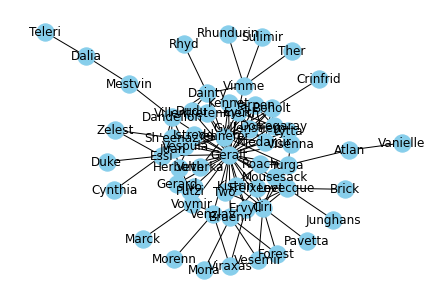

In [30]:
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color="skyblue", edge_cmap=plt.cm.Blues, pos = pos)

#### Graph Visualisation Pyvis

In [33]:
from pyvis.network import Network

net = Network(notebook=True, width="1000px", height="700px", bgcolor="#222222", font_color="white")

node_degree = dict(G.degree)

# Setting up node size attribute
nx.set_node_attributes(G, node_degree, "size")

net.from_nx(G)
net.show("witcher.html")

#### Background on Networks

There are many centrality measures, above we used **degree centrality** to see who are the main characters. This says that the nodes with the most connections are the "main" nodes. Some other measures are **highest betweeness** and **best closeness centrality**, the latter being the one which has the shortest distances to other nodes.

#### The Most Important Characters in the Witcher

In [34]:
# Degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict

{'Geralt': 0.5932203389830508,
 'Niedamir': 0.11864406779661017,
 'Eyck': 0.13559322033898305,
 'Dorregaray': 0.11864406779661017,
 'Yennefer': 0.2542372881355932,
 'Yarpen': 0.13559322033898305,
 'Gyllenstiern': 0.13559322033898305,
 'Kennet': 0.0847457627118644,
 'Boholt': 0.15254237288135594,
 'Crinfrid': 0.01694915254237288,
 'Villentretenmerth': 0.05084745762711865,
 'Istredd': 0.05084745762711865,
 'Herbolth': 0.03389830508474576,
 'Ivo': 0.01694915254237288,
 'Two': 0.05084745762711865,
 'Vespula': 0.05084745762711865,
 'Dainty': 0.0847457627118644,
 'Dandelion': 0.11864406779661017,
 'Rhyd': 0.01694915254237288,
 'Vimme': 0.0847457627118644,
 'Ther': 0.01694915254237288,
 'Sulimir': 0.01694915254237288,
 'Rhundurin': 0.01694915254237288,
 'Dudu': 0.05084745762711865,
 "Sh'eenaz": 0.0847457627118644,
 'Dalia': 0.03389830508474576,
 'Teleri': 0.01694915254237288,
 'Mestvin': 0.03389830508474576,
 'Essi': 0.11864406779661017,
 'Gerard': 0.01694915254237288,
 'Zelest': 0.0338983050

<AxesSubplot:>

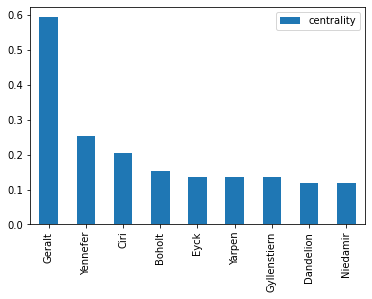

In [38]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient="index", columns=["centrality"])
# Plot top 10 nodes
def plot_nodes(df):
    return df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")
    
plot_nodes(degree_df)

<AxesSubplot:>

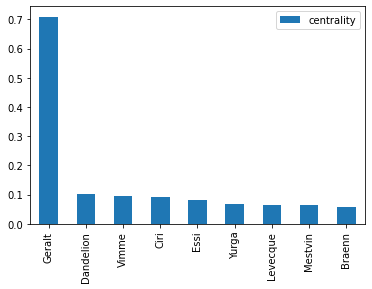

In [43]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
plot_nodes(betweenness_df)

# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient="index", columns=["centrality"])
plot_nodes(closeness_df)

In [44]:
# Save centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweeness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

#### Community detection

There are different algorithms for detecting communities but we will use louvain.

In [46]:
import community as community_louvain

In [47]:
communities = community_louvain.best_partition(G)

In [48]:
communities

{'Geralt': 0,
 'Niedamir': 1,
 'Eyck': 1,
 'Dorregaray': 1,
 'Yennefer': 1,
 'Yarpen': 1,
 'Gyllenstiern': 1,
 'Kennet': 1,
 'Boholt': 1,
 'Crinfrid': 1,
 'Villentretenmerth': 1,
 'Istredd': 0,
 'Herbolth': 0,
 'Ivo': 0,
 'Two': 0,
 'Vespula': 2,
 'Dainty': 2,
 'Dandelion': 2,
 'Rhyd': 2,
 'Vimme': 5,
 'Ther': 5,
 'Sulimir': 5,
 'Rhundurin': 5,
 'Dudu': 2,
 "Sh'eenaz": 2,
 'Dalia': 2,
 'Teleri': 2,
 'Mestvin': 2,
 'Essi': 2,
 'Gerard': 0,
 'Zelest': 2,
 'Duke': 2,
 'Veverka': 0,
 'Juan': 3,
 'Putzi': 3,
 'Cynthia': 2,
 'Braenn': 4,
 'Ciri': 4,
 'Marck': 4,
 'Voymir': 4,
 'Ervyll': 4,
 'Kistrin': 4,
 'Vesemir': 4,
 'Freixenet': 4,
 'Venzlav': 4,
 'Viraxas': 4,
 'Morenn': 4,
 'Mona': 4,
 'Forest': 4,
 'Pavetta': 4,
 'Levecque': 4,
 'Junghans': 4,
 'Brick': 4,
 'Mousesack': 4,
 'Yurga': 0,
 'Visenna': 0,
 'Atlan': 0,
 'Vanielle': 0,
 'Lytta': 0,
 'Roach': 0}

In [49]:
nx.set_node_attributes(G, communities, 'group')

In [52]:
com_net = Network(notebook=True, width="1000px", height="700px", bgcolor="#222222", font_color="white")
com_net.from_nx(G)
com_net.show("witcher_communities.html")